In [53]:
import json
from unskript import nbparams
from unskript.fwk.workflow import Task, Workflow
from unskript.secrets import ENV_MODE, ENV_MODE_LOCAL

env = {"ENV_MODE": "ENV_MODE_LOCAL"}
secret_store_cfg = {"SECRET_STORE_TYPE": "SECRET_STORE_TYPE_LOCAL"}

paramDict = {"end_date": "2023/02/22", "issue_type": "Bug", "jira_project": "EN", "new_status": "Done", "start_date": "2022/01/01"}
paramsJson = json.dumps(paramDict)
nbParamsObj = nbparams.NBParams(paramsJson)
end_date = nbParamsObj.get('end_date')
issue_type = nbParamsObj.get('issue_type')
jira_project = nbParamsObj.get('jira_project')
new_status = nbParamsObj.get('new_status')
start_date = nbParamsObj.get('start_date')
w = Workflow(env, secret_store_cfg, None, global_vars=globals())

<p>In this RunBook, We will graph MTTR of issues in Jira.</p>
<p>&nbsp;</p>
<p>Since many teams track DevOps issues in Jira, this is a great way to understand how quickly issues are getting resolved, and if the MTTR is improving.</p>
<p>&nbsp;</p>
<p>First we will get a static pull of all the issues in Jira.&nbsp; This is fine if your data set is small, but we'll also generate the graph dynamically - so that the data pulled from Jira is never "too big."</p>

<p>By defining the JQL query in this way, we can reuse the "get issues from JIRA" Action with different start and end times to pull different timeframes from Jira.</p>
<p>&nbsp;</p>
<p>For the static chart, we use a big start and end time, to pull all the data in.</p>

In [93]:
start = start_date
end = end_date
#global jql_query
jql_query=""
def create_query(jira_project, issue_type, new_status, start, end) -> str: 
    #global jql_query
    return f'project = {jira_project} and issueType = {issue_type} and status changed to {new_status} during ("{start}","{end}")'
jql_query = create_query(jira_project, issue_type, new_status, start, end)
print(jql_query)


project = EN and issueType = Bug and status changed to Done during ("2022/01/01","2023/02/22")


<p>We;ve created the JQL query - this pre-built Action just pulls the requested data from Jira.:<br><br></p>
<pre>project = EN and issueType = Bug and status changed to Done during ('2022/01/01','2023/01/08')</pre>
<p>&nbsp;</p>
<p>This query pulls all bgs from the EN project that were completed from 1/1/2022 - 1/8/2023.</p>

In [94]:
##
# Copyright (c) 2021 unSkript, Inc
# All rights reserved.
##
from jira import JIRA, Issue
from pydantic import BaseModel, Field
from typing import Optional, List, Dict
import pprint

pp = pprint.PrettyPrinter(indent=4)


from beartype import beartype
@beartype
def legoPrinter(func):
    def Printer(*args, **kwargs):
        matching_issues = func(*args, **kwargs)
        print('\n')
        #for issue in matching_issues:
         #  print('ID:{}: Summary:{} Description:{}'.format(
         #       issue.key, issue.fields.summary, issue.fields.description))
            #print(issue)

        return matching_issues
    return Printer


@legoPrinter
@beartype
def jira_search_issue(handle: JIRA, jql: str, max_results: int = 0) -> List:
    """jira_search_issue get Jira issues matching JQL queries.
        :type jql: str
        :param jql: Search string to execute in JIRA.

        :type max_results: int
        :param max_results: Max limit on number of matching issues

        :rtype: Jira issues matching JQL queries
    """
    print("jql search lego",jql)
    matching_issues = handle.search_issues(jql, maxResults=max_results)

    return matching_issues


def unskript_default_printer(output):
    if isinstance(output, (list, tuple)):
        for item in output:
            print(f'item: {item}')
    elif isinstance(output, dict):
        for item in output.items():
            print(f'item: {item}')
    else:
        print(f'Output for {task.name}')
        print(output)

task = Task(Workflow())
task.configure(credentialsJson='''{
}''')
task.configure(inputParamsJson='''{
    "jql": "jql_query"
    }''')

task.configure(outputName="issueList")
task.configure(printOutput=False)
(err, hdl, args) = task.validate(vars=vars())
if err is None:
    task.execute(jira_search_issue, lego_printer=unskript_default_printer, hdl=hdl, args=args)

jql search lego project = EN and issueType = Bug and status changed to Done during ("2022/01/01","2023/02/22")


Task Executed


<p>In this Action - we convert the object from Jira into a Dict, and we add the elapsed time.&nbsp;&nbsp;</p>
<p>&nbsp;</p>
<p>This is the time from the bug being opened to the status changed to closed.&nbsp; We save this as a timedelta, but also convert the timedelta into hours - adding the days (*24) and seconds (/3600) of the timedelta so that we can see how many hours the ticket was open.</p>
<p>&nbsp;</p>
<p>We also count the number of issues in the Dict and print that value.</p>

In [35]:
from datetime import datetime
def create_dict(issueList):

    issue_data = {}
    counter =0
    for issue in issueList:
        counter +=1
        create_time = datetime.strptime(issue.fields.created, '%Y-%m-%dT%H:%M:%S.%f%z')
        done_time = datetime.strptime(issue.fields.updated, '%Y-%m-%dT%H:%M:%S.%f%z')
        elapsed_time = done_time-create_time
        elapsed_time_hours = round(elapsed_time.days*24,0) +round(elapsed_time.seconds/3600,1)
        #print("elapsed", elapsed_time)
        assignee = issue.fields.assignee
        if hasattr(issue.fields.assignee,'displayName'):
            assignee = issue.fields.assignee.displayName
        else:
            assignee = "Not assigned"
        issue_data[issue.key] = {#"summary": issue.fields.summary, 
                                     #"description": issue.fields.description,
                                     "reporter":issue.fields.reporter.displayName,
                                     "status":issue.fields.status.name,
                                     "issueType":issue.fields.issuetype.name,
                                     "project":issue.fields.project.name,
                                     "create_time":create_time,
                                     "done_time":done_time,
                                     "elapsed_time":elapsed_time,
                                     "elapsed_time_hours":elapsed_time_hours,
                                     "assignee":assignee
                                    }
    print("counter", counter)
    return issue_data
issue_data = create_dict(issueList)

counter 183


<p>this step is doing a lot.</p>
<p>&nbsp;</p>
<ol>
<li>pulls the Dict into a dataframe.</li>
<li>builds the chart with Panel.
<ol>
<li>Chart is built</li>
<li>pulls the data from weekdef - which calculates the start and end date- and filters the datafram into a smaller dataframe with the elapsed time in hours&nbsp; - chunked into 4 bins.&nbsp; These are then charted.</li>
<li>The sliderstart value might be different for your organization.&nbsp; You can hard code this here,</li>
<li>The intervals are set in 7 day increments in the daycount slider</li>
</ol>
</li>
</ol>

Column
    [0] DateSlider(end=datetime.datetime(2023, ..., name='Date Slider', start=datetime.datetime(2022, ..., value=datetime.datetime(2023, ...)
    [1] IntSlider(end=180, name='number of days', start=1, step=7, value=7)
    [2] ParamFunction(function)
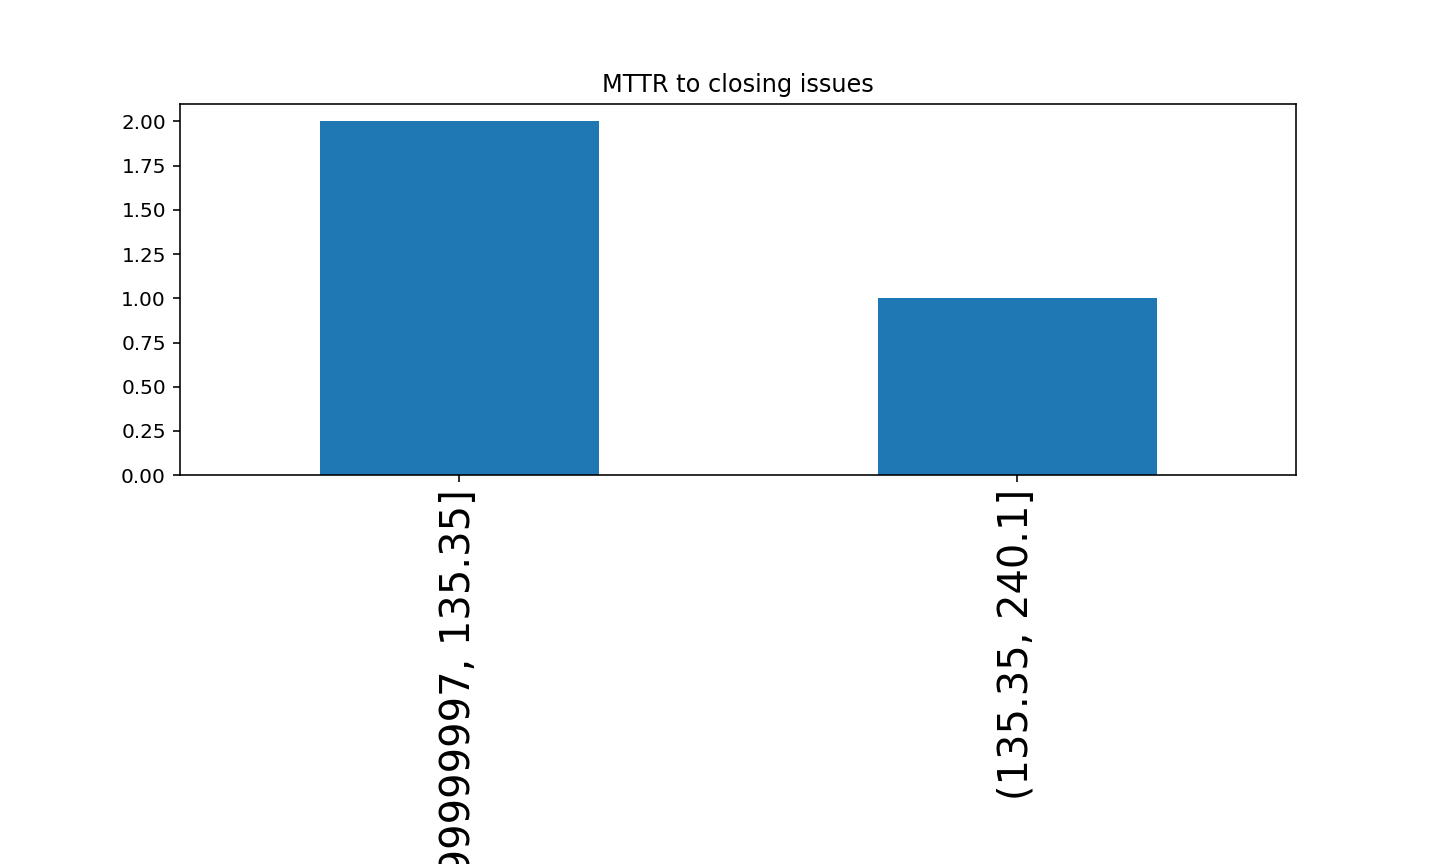

In [102]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt
import panel as pn
import datetime as dt
from datetime import timezone

from matplotlib.backends.backend_agg import FigureCanvas
from matplotlib.figure import Figure
pn.extension()

#create a dataframe from the Jira export
data = pd.DataFrame.from_dict(issue_data)
data = data.T
#data.tail

def weekdf(startDay, dayCount, dataframe):
    startDay = datetime.combine(startDay, datetime.min.time())
    startDay =startDay.replace(tzinfo=timezone.utc)
    endDay =startDay+ dt.timedelta(days=dayCount)
    #print(startDay, endDay)
    weekdf= dataframe[(dataframe["create_time"] >= startDay)&(dataframe["create_time"] <= endDay) ]["elapsed_time_hours"].value_counts()
    weektitle = "Defect status by creation date"
    if weekdf.empty:
        startDay =dt.datetime(2021, 1, 1,0,0,0)
        startDay =startDay.replace(tzinfo=timezone.utc)
        dayCount=730
        endDay =startDay+ dt.timedelta(days=dayCount)
        weektitle = "no data for this week."
        weekdf= dataframe[(dataframe["create_time"] >= startDay)&(dataframe["create_time"] <= endDay) ]["elapsed_time_hours"].value_counts(bins=4, sort=False)
    else:
         issueCount = weekdf.sum(0)
         numberofBins = 4
         if issueCount < 4:
                numberofBins = 2
         if issueCount > 15:
                numberofBins = 8
         weekdf= dataframe[(dataframe["create_time"] >= startDay)&(dataframe["create_time"] <= endDay) ]["elapsed_time_hours"].value_counts(bins=numberofBins, sort=False)
    #print("count", weekdf.sum(0))
    return weekdf


def time_plot(startDay, dayCount, dataframe):
    fig = Figure(figsize=(10, 6))
    fig.subplots_adjust(bottom=0.45)

    ax = fig.subplots()
    ax.xaxis.set_tick_params(labelsize=20)
    df1 = weekdf(startDay, dayCount, dataframe)
    FigureCanvas(fig) 
    df1.plot.bar(x="x", y="counts", ax=ax, title="MTTR to closing issues")
    return fig



#build the chart

#get all our date-time variables correctly formatted with a timezone.
sliderstart = dt.datetime(2022, 1, 1,0,0,0)
sliderstart =sliderstart.replace(tzinfo=timezone.utc)
sliderend = dt.datetime.now()
sliderend =sliderend.replace(tzinfo=timezone.utc)
slidervalue = dt.datetime(2023, 1, 1,0,0,0)
slidervalue =slidervalue.replace(tzinfo=timezone.utc)
#print("sliderstart",sliderstart)


#CREATE SLIDERS
startDay = pn.widgets.DateSlider(name='Date Slider', start=sliderstart, end=sliderend, value=slidervalue)

dayCount = pn.widgets.IntSlider(name='number of days', value=7, start=1, end=180, step = 7)
interactive = pn.bind(time_plot, startDay=startDay, dayCount=dayCount, dataframe = data)
first_app = pn.Column(startDay, dayCount, interactive)
first_app


<p>The above steps are great if your dataset isn't very large.&nbsp; But what if you have thousands of issues?&nbsp; We dont want to make epic JQL queries, and then also hammer the RUnBook with a huge amount of data.&nbsp;&nbsp;</p>
<p>&nbsp;</p>
<p>Let's pull the data every time we change the graph.&nbsp; This is REALLY useful for time sensitive data (imagine you need time sensitive data, and pulling a whole day's of data takes forever.). Now, pull the small subset you need in real time when you create the chart</p>

jql_query project = EN and issueType = Bug and status changed to Done during ("2023/01/01","2023/01/08")
stringifiedInput {"jql": "project = EN and issueType = Bug and status changed to Done during (\"2023/01/01\",\"2023/01/08\")"} <class 'str'>
jql search lego project = EN and issueType = Bug and status changed to Done during ("2023/01/01","2023/01/08")


Task Executed
issueList1 8
counter 8
livedata 72


jql_query project = EN and issueType = Bug and status changed to Done during ("2022/08/31","2022/09/07") 
stringifiedInput {"jql": "project = EN and issueType = Bug and status changed to Done during (\"2022/08/31\",\"2022/09/07\")"} 
jql search lego project = EN and issueType = Bug and status changed to Done during ("2022/08/31","2022/09/07") 
 
 
Task Executed 
issueList1 1 
counter 1 
livedata 9 
jql_query project = EN and issueType = Bug and status changed to Done during ("2022/08/31","2022/09/22") 
stringifiedInput {"jql": "project = EN and issueType = Bug and status changed to Done during (\"2022/08/31\",\"2022/09/22\")"} 
jql search lego project = EN and issueType = Bug and status changed to Done during ("2022/08/31","2022/09/22") 
 
 
Task Executed 
issueList1 9 
counter 9 
livedata 81 
jql_query project = EN and issueType = Bug and status changed to Done during ("2022/08/31","2022/11/17") 
stringifiedInput {"jql": "project = EN and issueType = Bug and status changed to Done during (\"2022/08/31\",\"2022/11/17\")"} 
jql search lego project = EN and issueType = Bug and status changed to Done during ("2022/08/31","2022/11/17") 
 
 
Task Executed 
issueList1 23 
counter 23 
livedata 207 
jql_query project = EN and issueType = Bug and status changed to Done during ("2022/08/31","2022/11/10") 
stringifiedInput {"jql": "project = EN and issueType = Bug and status changed to Done during (\"2022/08/31\",\"2022/11/10\")"} 
jql search lego project = EN and issueType = Bug and status changed to Done during ("2022/08/31","2022/11/10") 
 
 
Task Executed 
issueList1 19 
counter 19 
livedata 171 
jql_query project = EN and issueType = Bug and status changed to Done during ("2022/08/31","2022/11/03") 
stringifiedInput {"jql": "project = EN and issueType = Bug and status changed to Done during (\"2022/08/31\",\"2022/11/03\")"} 
jql search lego project = EN and issueType = Bug and status changed to Done during ("2022/08/31","2022/11/03") 
 
 
Task Executed 
issueList1 17 
counter 17 
livedata 153

Column
    [0] DateSlider(end=datetime.datetime(2023, ..., name='Date Slider', start=datetime.datetime(2022, ..., value=datetime.datetime(2023, ...)
    [1] IntSlider(end=180, name='number of days', start=1, step=7, value=7)
    [2] ParamFunction(function)
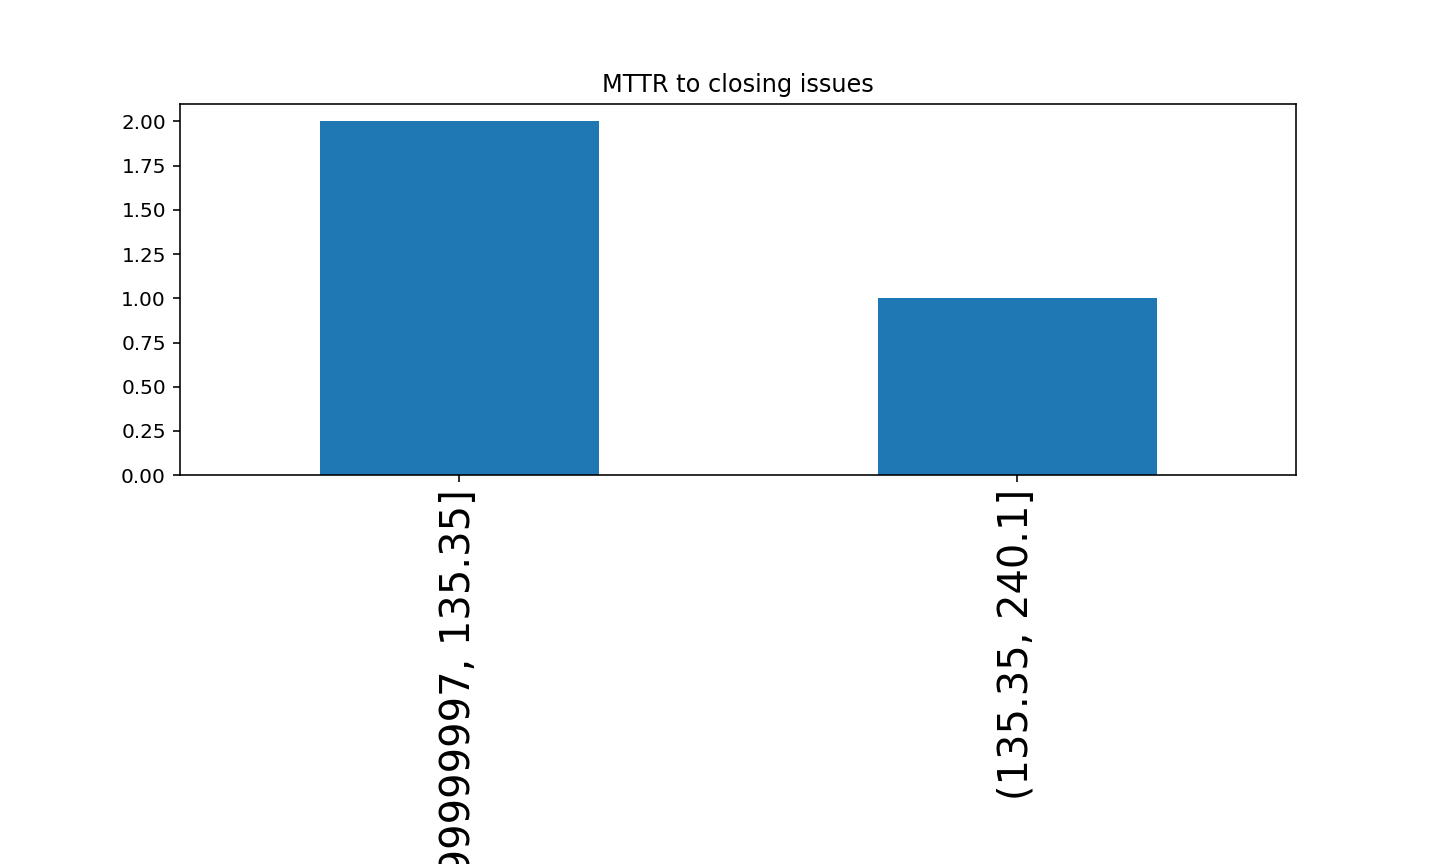

In [101]:
import json
#create a dataframe from the Jira export
livedata = data

#data.tail

def weekdflive(startDay, dayCount, dataframe):
    startDay = datetime.combine(startDay, datetime.min.time())
    startDay =startDay.replace(tzinfo=timezone.utc)
    endDay =startDay+ dt.timedelta(days=dayCount)
    #pull data from JIRA
    startJira = startDay.strftime("%Y/%m/%d")
    endJira = endDay.strftime("%Y/%m/%d")
    jql_query =create_query(jira_project, issue_type, new_status, startJira, endJira)
    print("jql_query",jql_query)
    jsonInput = {"jql":jql_query}
    stringifiedInput = json.dumps(jsonInput)
    print("stringifiedInput",stringifiedInput, type(stringifiedInput))
    #inputParamsJson1 = f'''{"jql":{{jql_query}}}'''
    #print("inputParamsJson1", inputParamsJson1)
   


    task.configure(inputParamsJson='''{
        "jql": "jql_query"
        }''')
    task.configure(outputName="issueList1")
    (err, hdl, args) = task.validate(vars=vars())
    task.execute(jira_search_issue, lego_printer=unskript_default_printer, hdl=hdl, args=args)

    print("issueList1", len(issueList1))
    live_issue_data = create_dict(issueList1)
    livedata=""
    livedata = pd.DataFrame.from_dict(live_issue_data)
    livedata = livedata.T
    print("livedata" ,livedata.size)
    
    
    
    weekdf= dataframe[(dataframe["create_time"] >= startDay)&(dataframe["create_time"] <= endDay) ]["elapsed_time_hours"].value_counts()
    weektitle = "Defect status by creation date"
    if weekdf.empty:
        startDay =dt.datetime(2021, 1, 1,0,0,0)
        startDay =startDay.replace(tzinfo=timezone.utc)
        dayCount=730
        endDay =startDay+ dt.timedelta(days=dayCount)
        weektitle = "no data for this week."
        weekdf= dataframe[(dataframe["create_time"] >= startDay)&(dataframe["create_time"] <= endDay) ]["elapsed_time_hours"].value_counts(bins=4, sort=False)
    else:
         issueCount = weekdf.sum(0)
         numberofBins = 4
         if issueCount < 4:
                numberofBins = 2
         if issueCount > 15:
                numberofBins = 8
         weekdf= dataframe[(dataframe["create_time"] >= startDay)&(dataframe["create_time"] <= endDay) ]["elapsed_time_hours"].value_counts(bins=numberofBins, sort=False)
    #print("count", weekdf.sum(0))
    return weekdf


def time_plotlive(startDay, dayCount, dataframe):
    fig = Figure(figsize=(10, 6))
    fig.subplots_adjust(bottom=0.45)

    ax = fig.subplots()
    ax.xaxis.set_tick_params(labelsize=20)
    df1 = weekdflive(startDay, dayCount, dataframe)
    FigureCanvas(fig) 
    df1.plot.bar(x="x", y="counts", ax=ax, title="MTTR to closing issues")
    return fig



#build the chart

#get all our date-time variables correctly formatted with a timezone.
sliderstart = dt.datetime(2022, 1, 1,0,0,0)
sliderstart =sliderstart.replace(tzinfo=timezone.utc)
sliderend = dt.datetime.now()
sliderend =sliderend.replace(tzinfo=timezone.utc)
slidervalue = dt.datetime(2023, 1, 1,0,0,0)
slidervalue =slidervalue.replace(tzinfo=timezone.utc)
#print("sliderstart",sliderstart)


#CREATE SLIDERS
startDay = pn.widgets.DateSlider(name='Date Slider', start=sliderstart, end=sliderend, value=slidervalue)

dayCount = pn.widgets.IntSlider(name='number of days', value=7, start=1, end=180, step = 7)
interactive = pn.bind(time_plotlive, startDay=startDay, dayCount=dayCount, dataframe = livedata)
first_app = pn.Column(startDay, dayCount, interactive)
first_app
